In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from dialz import Dataset, SteeringModel, SteeringVector, visualize_activation, get_activation_score

load_dotenv()
hf_token = os.getenv("HF_TOKEN")

### Layer Visualization

In [3]:
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
dataset = Dataset.load_dataset(model_name, 'morality')
## Initialize a steering model that activates on layers 10 to 19
model = SteeringModel(model_name, layer_ids=list(range(10,20)), token=hf_token)

## Train the steering vector using the above model and dataset
vector = SteeringVector.train(model, dataset)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:02<00:00, 15.21it/s]


In [4]:

df = pd.read_csv("../data/hate_speech_binary.csv")

hate_texts = df.nlargest(5, 'hate_speech_score')['text'].tolist()
love_texts = df.nsmallest(5, 'hate_speech_score')['text'].tolist()

longest_hate_text = (
    df[df['label'] == 1]
      .loc[ df[df['label'] == 1]['text'].str.len().idxmax(), 'text' ]
)
longest_love_text = (
    df[df['label'] == 0]
      .loc[ df[df['label'] == 0]['text'].str.len().idxmax(), 'text' ]
)

# for layer in range(1,32):
#     print(f"Layer {layer}: \t" + (visualize_activation(longest_love_text, model, vector, layer_index=layer)))

for text in hate_texts:
    print((visualize_activation(text, model, vector, layer_index=16)))


for text in love_texts:
    print((visualize_activation(text, model, vector, layer_index=16)))

Dig burn PITS and treat them THE INVADING NAZIS ALL OVER EUROPE. ESPECIALLY THE WOMEN DON'T LET THEM BREED HERE MR. PRESIDENT. FIRING SQUADS SO I CAN VOLUNTEER
fr diva gays are the worst types of faggots. take some phenobarbital and chill b4 i come for your whole life
KILL THEM ALL PUT THEM HOES TO REST WALK IN BULLETPROOF VEST
I wanna abuse that worthless whore ass for hours
No fuck off. You are all lost causes and all of you deserve a painful death. No one can or ever will forgive you POS virgins. Hope someone comes and splits all your throats like you truly deserve
Fellow trans girl here! Love and support confirmed!
There's a church near where in live that used to be unoccupied and so it was transformed into a Sikh temple. Wanting to respect it's original faith, Christians are still welcome to come in and pray and they regularly do cross-faith services and events. It's really lovely.
For my brave girls all over the world defying modesty/rape culture and choosing personal freedom, I'

In [ ]:
# Create a random subset of 500 rows from the existing dataframe
df_subset = df.sample(n=500, random_state=42)

# Optionally, display the subset to verify its size and content
print(df_subset.head())
print("Subset size:", df_subset.shape[0])



                                                    text  hate_speech_score  \
10146                           Another worthless kafir.               1.78   
8011   @OneishaMarshae a real mental illness is creat...               1.39   
11176  Im stuck with the same niggas I been starving ...               1.83   
8447   The Reform Movement's most recent siddur "Mish...              -3.94   
360    Gender is such a silly reason to oppress half ...              -4.26   

       comment_id  annotator_id  label  
10146       49216          7045      1  
8011        28683          7181      1  
11176       39585         10743      1  
8447         2208         11038      0  
360         31473          5672      0  
Subset size: 500


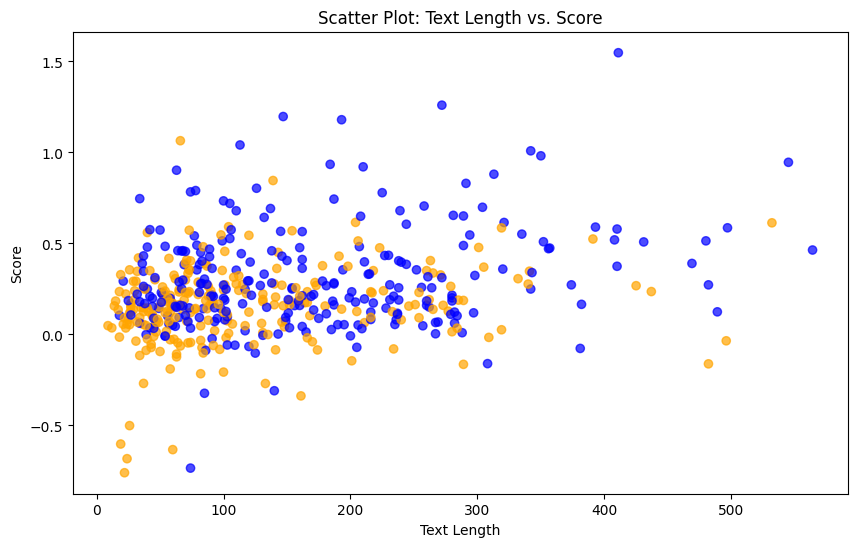

In [ ]:

for layer in range(1,31):
    df_subset['score'] = df_subset['text'].apply(lambda x: get_activation_score(x, model, vector, layer_index=layer, scoring_method="final_token"))
    plt.figure(figsize=(10, 6))
    colors = df_subset['label'].map({0: 'blue', 1: 'orange'})
    plt.scatter(df_subset['text'].str.len(), df_subset['score'], c=colors, alpha=0.7)
    plt.xlabel('Text Length')
    plt.ylabel('Score')
    plt.title('Scatter Plot: Text Length vs. Score')
    plt.savefig(f'../figs/layer_{layer}.png')


Saved multi-layer scatter plot to ../figs/all_layers_scatter.png


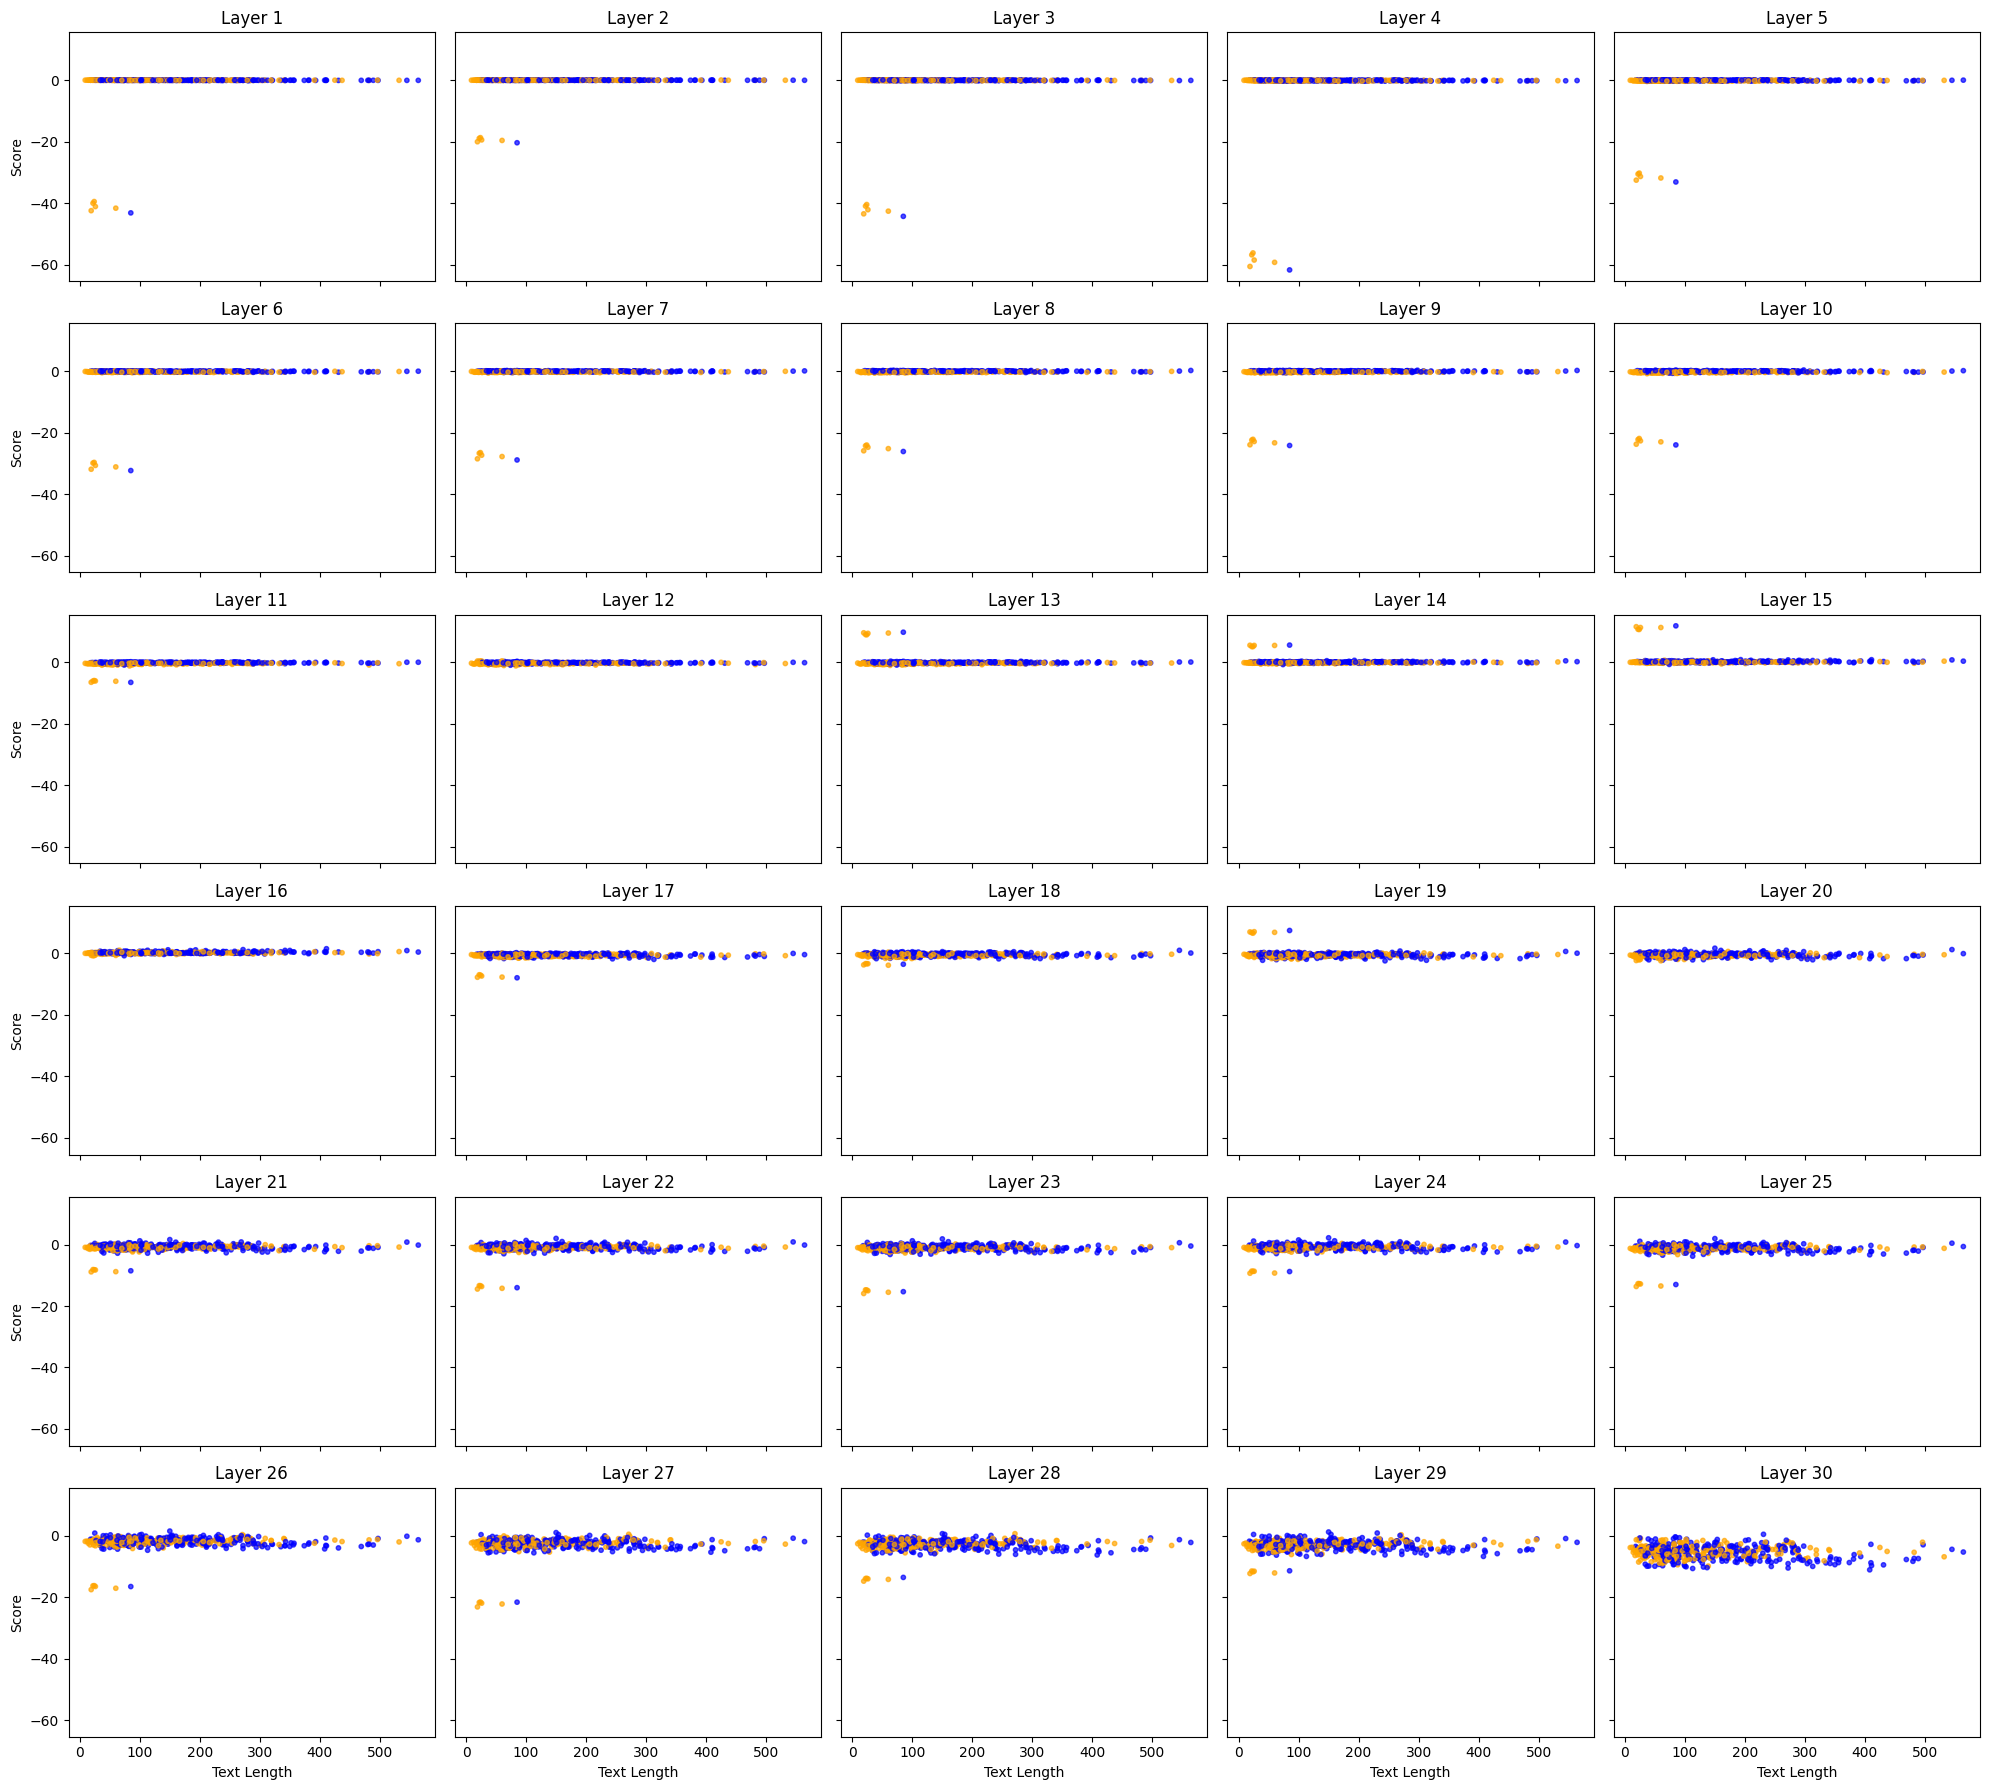

In [ ]:
import matplotlib.pyplot as plt

# Configuration
n_layers = 30
n_cols = 5
n_rows = (n_layers + n_cols - 1) // n_cols  # Ceil division

# Create subplots
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 4, n_rows * 3),
    sharex=True, sharey=True
)
axes = axes.flatten()

# Generate plots
for layer in range(1, n_layers + 1):
    ax = axes[layer - 1]
    
    # Compute activation scores for this layer
    df_subset['score'] = df_subset['text'].apply(
        lambda x: get_activation_score(
            x, model, vector,
            layer_index=layer,
            scoring_method="final_token"
        )
    )
    colors = df_subset['label'].map({0: 'blue', 1: 'orange'})

    ax.scatter(
        df_subset['text'].str.len(),
        df_subset['score'],
        c=colors, alpha=0.7, s=10
    )
    ax.set_title(f'Layer {layer}')
    ax.set_ylim(-3, 3)

    if layer % n_cols == 1:
        ax.set_ylabel('Score')
    if layer > (n_rows - 1) * n_cols:
        ax.set_xlabel('Text Length')

# Turn off unused axes
for idx in range(n_layers, len(axes)):
    axes[idx].axis('off')

# Layout adjustment and save
fig.tight_layout()
output_path = '../figs/all_layers_scatter.png'
fig.savefig(output_path, dpi=300)
print(f"Saved multi-layer scatter plot to {output_path}")
